<a href="https://colab.research.google.com/github/enerdb/cats_and_dogs/blob/main/cats_and_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Data

In [1]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip


--2021-09-23 18:29:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 64.233.170.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   154MB/s    in 0.4s    

2021-09-23 18:29:04 (154 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [ ]:
!unzip cats_and_dogs_filtered.zip

In [3]:
!rm -rf cats_and_dogs_filtered.zip

In [ ]:
!pip install tensorflow

# Imports

In [5]:
# os auxilia em tarefes no Sistema operacional
import os
# plotar imagens
import matplotlib.pyplot as plt
# implementação do modelo
import tensorflow as tf


# Ploting functions

In [11]:
# Function to display images of a dataset

def plot_dataset(dataset):

  plt.gcf().clear()
  plt.figure(figsize = (15,15))

  for features, labels in dataset.take(1):
      for i in range(9):
    
          plt.subplot(3, 3, i+1)
          plt.axis('off')

          plt.imshow(features[i].numpy().astype('uint8'))
          plt.title(class_names[labels[i]])


In [32]:
# plot an augmented dataset 

def plot_dataset_data_augmentation(dataset):

  plt.gcf().clear()
  plt.figure(figsize = (15,15))

  for features, _ in dataset.take(1):
    
    feature = features[0]

    for i in range(9):

      feature_data_augmentation = data_augmentation(tf.expand_dims(feature, 0))

      plt.subplot(3, 3, i+1)
      plt.axis('off')

      plt.imshow(feature_data_augmentation[0] / image_color_channel_size)

In [43]:
def plot_model():
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.gcf().clear()
  plt.figure(figsize = (15,8))

  plt.subplot(1,2,1)
  plt.title('Trainig and Validation Accuracy')
  plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
  plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
  plt.legend(loc = 'lower right')

  plt.subplot(1,2,2)
  plt.title('Training and Validation Loss')
  plt.plot(epochs_range, loss, label = 'Training Loss')
  plt.plot(epochs_range, val_loss, label = 'Validation Loss')

  plt.legend(loc = 'lower right')
  
  plt.show()


In [20]:
def plot_dataset_predictions(dataset):

  features, labels = dataset.as_numpy_iterator().next()

  predictions_aux = model.predict_on_batch(features).flatten()
  predictions = tf.where(predictions_aux <0.5, 0, 1)

  print('Labels:      %s' % labels)
  print('Predictions: %s' % predictions.numpy())

  plt.gcf().clear()
  plt.figure(figsize = (15,15))

  for i in range(9):

    plt.subplot(3,3, i + 1)
    plt.axis('off')

    plt.imshow(features[i].astype('uint8'))
    plt.title(class_names[predictions[i]])


# Data Description

In [6]:
dataset_dir = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')

dataset_train_dir = os.path.join(dataset_dir, 'train')
dataset_train_cats_len = len(os.listdir(os.path.join(dataset_train_dir, 'cats')))
dataset_train_dogs_len = len(os.listdir(os.path.join(dataset_train_dir, 'dogs')))

dataset_validation_dir = os.path.join(dataset_dir, 'validation')
dataset_validation_cats_len = len(os.listdir(os.path.join(dataset_validation_dir, 'cats')))
dataset_validation_dogs_len = len(os.listdir(os.path.join(dataset_validation_dir, 'dogs')))

print('Train Cats: %s' % dataset_train_cats_len)
print('Train Dogs: %s' % dataset_train_dogs_len)
print('Validation Cats: %s' % dataset_validation_cats_len)
print('Validation Dogs: %s' % dataset_validation_dogs_len)

Train Cats: 1000
Train Dogs: 1000
Validation Cats: 500
Validation Dogs: 500


Preprocessing:

Size: 160x160 (scaling)
Value by color 0-255 RGB


## Image parameter setting

In [7]:
image_width = 160
image_height = 160
image_color_channel = 3
image_color_channel_size = 255
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel, )

# number of features used per batch
batch_size = 32 
# number of times the dataset will participate n training
epochs = 20
# learning rate
learning_rate = 0.0001

class_names = ['cat', 'dog']

In [8]:
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_train_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 2000 files belonging to 2 classes.


In [9]:
dataset_validation_pre = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_validation_dir,
    image_size = image_size,
    batch_size = batch_size,
    shuffle = True
)

Found 1000 files belonging to 2 classes.


In [10]:
dataset_validation_cardinality = tf.data.experimental.cardinality(dataset_validation_pre)
dataset_validation_batches = dataset_validation_cardinality // 5

dataset_test = dataset_validation_pre.take(dataset_validation_batches)
dataset_validation = dataset_validation_pre.skip(dataset_validation_batches)

print('Validation Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_validation))
print('Test Dataset Cardinality: %d' % tf.data.experimental.cardinality(dataset_test))



Validation Dataset Cardinality: 26
Test Dataset Cardinality: 6


In [27]:
# Creates new features (images) using the features we have
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2)                                               
])

In [34]:
# plot_dataset_data_augmentation(dataset_train)

In [35]:
# Uses part of a pretrained model with much more data and layers in our model
# This helps a lot in image classification

model_transfer_learning = tf.keras.applications.MobileNetV2(
    input_shape = image_shape,
    include_top = False, 
    weights = 'imagenet'
)

model_transfer_learning.trainable = False # do not update model parameters

# model_transfer_learning.summary()

# Model Training

In [36]:
# chose a model 0 (old) or 1 (new)
chosen_model = 1

if chosen_model == 0:
  # Sequential - each layer is applied after the other
  model = tf.keras.models.Sequential([
      # Rescaling (160, 160, 3), values from 0 to 1
      tf.keras.layers.experimental.preprocessing.Rescaling(
          1. /image_color_channel_size,
          input_shape = image_shape
      ),
      # Convolutional Layer, Kernel 3x3 passed 16x
      # padding = same - zeros around feature
      # activation function = relu - zero if negative
      tf.keras.layers.Conv2D(16, 3, padding = 'same', activation = 'relu'), # double layer size
      # MaxPooling consolidates the activation map from a Convolution layer
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(32, 3, padding = 'same', activation = 'relu'), # double layer size
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Conv2D(64, 3, padding = 'same', activation = 'relu'), # double layer size
      tf.keras.layers.MaxPooling2D(),
      # Flattens the output
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(128, activation = 'relu'), # double layer size
      tf.keras.layers.Dense(1, activation= 'sigmoid')
  ])

elif chosen_model == 1:
 model = tf.keras.models.Sequential([
      # Rescaling (160, 160, 3), values from -1 to 1
      tf.keras.layers.experimental.preprocessing.Rescaling(
          1. / (image_color_channel_size/2),
          offset = -1,
          input_shape = image_shape
      ),
      data_augmentation,
      model_transfer_learning,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(1, activation= 'sigmoid')
  ])

#

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy']
)

model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
________________________________________

In [37]:
history = model.fit(
    dataset_train,
    validation_data = dataset_validation,
    epochs = epochs
)

Epoch 1/20
63/63 [==============================] - 57s 850ms/step - loss: 0.6358 - accuracy: 0.6525 - val_loss: 0.4510 - val_accuracy: 0.8144
Epoch 2/20
63/63 [==============================] - 54s 863ms/step - loss: 0.4861 - accuracy: 0.7755 - val_loss: 0.3361 - val_accuracy: 0.8861
Epoch 3/20
63/63 [==============================] - 53s 845ms/step - loss: 0.4088 - accuracy: 0.8275 - val_loss: 0.2796 - val_accuracy: 0.9134
Epoch 4/20
63/63 [==============================] - 53s 847ms/step - loss: 0.3606 - accuracy: 0.8540 - val_loss: 0.2317 - val_accuracy: 0.9394
Epoch 5/20
63/63 [==============================] - 53s 846ms/step - loss: 0.3038 - accuracy: 0.8775 - val_loss: 0.2011 - val_accuracy: 0.9468
Epoch 6/20
63/63 [==============================] - 53s 846ms/step - loss: 0.2902 - accuracy: 0.8870 - val_loss: 0.1792 - val_accuracy: 0.9567
Epoch 7/20
63/63 [==============================] - 53s 844ms/step - loss: 0.2704 - accuracy: 0.8900 - val_loss: 0.1677 - val_accuracy: 0.9542

# Model Evaluation

<Figure size 432x288 with 0 Axes>

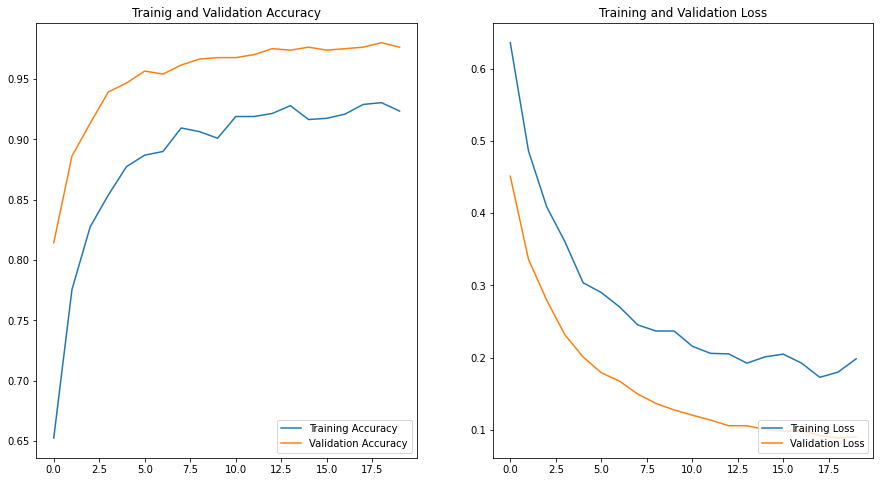

In [44]:
plot_model()

Labels:      [0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0]
Predictions: [0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0]


<Figure size 432x288 with 0 Axes>

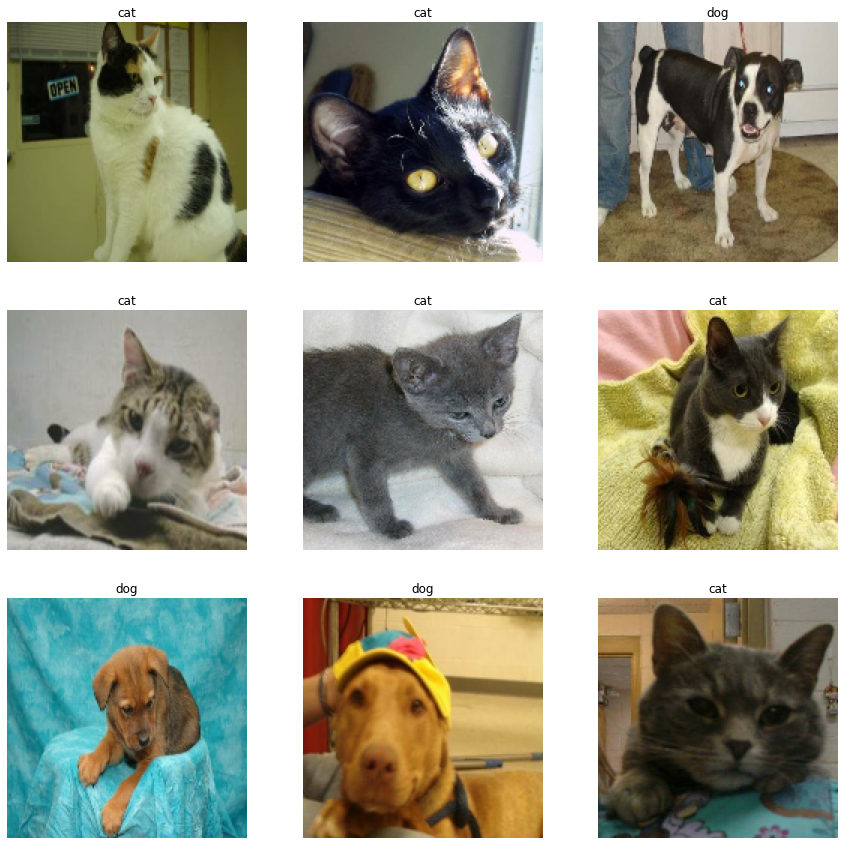

In [45]:
plot_dataset_predictions(dataset_test)

In [ ]:
# save model for production
# model.save('path/to/model')

In [19]:
# load saved model
# model = tf.keras.load_model('path/to')